this script checks the coverage difference in 2009 and 2018 to address reviewer #1's question

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
raw_path = "../../data/NationalFunding/Data/RobustCheck/check_09_and_18/funding_year_check.txt"
res_path = "../../data/NationalFunding/Data/RobustCheck/check_09_and_18/funding_year_check_result.xlsx"

In [3]:
res_df = pd.read_excel(res_path)
res_df.head(2)

,ost_bk,ut,year,title,label
0,65041047,WOS:000265236000001,2009,Symbolic Computations and Exact and Explicit S...,0.0
1,32590270,WOS:000266300300033,2009,Experiencing the pediatric intensive care unit...,0.0


remove articles without acccess and articles without verification

In [4]:
res_df = res_df[res_df.label.isin([0,1])]

calculate the information missing rates using bootstrapping

In [6]:
results =[]
for year in [2009, 2018]:
    df = res_df[res_df.year==year]
    #n_values = range(10,151,10)
    n_values = [150]
    num_iterations=100
    for n in n_values:
        ratios = []

        for _ in range(num_iterations):
            sample=df.sample(n, replace=True)
            ratio_of_1 = sample['label'].mean()
            results.append([year,n,ratio_of_1])
bootstrap=pd.DataFrame(results, columns=['year','size','ratio'])

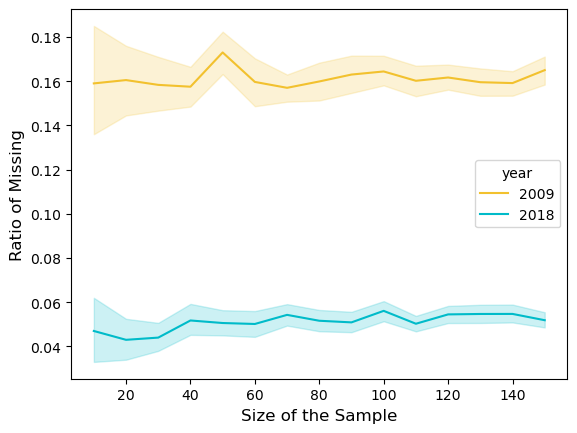

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='size',y='ratio',hue='year',errorbar='ci', data=bstrp, palette=['#F2C12E','#00BBC9'],ax=ax)
plt.xlabel("Size of the Sample", fontsize=12)
plt.ylabel("Ratio of Missing", fontsize=12)
plt.savefig("../../data/NationalFunding/Data/RobustCheck/ratio_of_missing_funding.pdf")

In [7]:
def cal_ci(df):
    ci_df = df.groupby(['year','size'])['ratio'].agg([np.mean, stats.sem])
    ci_df['error']=ci_df['sem']*1.96
    ci_df['upper'] = ci_df['mean']+ci_df['error']
    ci_df['low'] = ci_df['mean']-ci_df['error']
    ci_df = ci_df.reset_index()
    return ci_df

In [8]:
ci_df = cal_ci(bootstrap)

In [9]:
ci_df.head()

,year,size,mean,sem,error,upper,low
0,2009,150,0.1610,0.002873,0.005631,0.166631,0.155369
1,2018,150,0.0544,0.001678,0.003290,0.057690,0.051110


In [39]:
stats_df = pd.read_csv("../../data/NationalFunding/Data/RobustCheck/check_09_and_18/global_us_chn_stats.csv")

In [40]:
stats_df = stats_df.pivot(index=['cntry','year'],columns='type',values='value')
stats_df.head(2)

type        funded  notfunded   total
cntry year                           
china 2009   88044      34350  122394
      2018  337747      55973  393720

In [21]:
ci_df.set_index(['year','size'],inplace=True)
ci_df.head(2)

mean       sem     error     upper       low
year size                                                
2009 10    0.1520  0.011589  0.022714  0.174714  0.129286
     20    0.1485  0.008600  0.016857  0.165357  0.131643

In [41]:
def calibrate_with_false_negative(total, funded, notfunded, mean, upper, low):
    missed = notfunded*mean
    missed_upper = notfunded*upper
    missed_low = notfunded*low
    estimated_funded = funded+missed
    estimated_upper = funded+missed_upper
    estimated_low = funded+missed_low
    return estimated_funded, estimated_upper, estimated_low

In [31]:
world_df = stats_df[stats_df.cntry=='world']
world_df.head()

type,cntry,year,funded,notfunded,total
4,world,2009,531320,507318,1038638
5,world,2018,1051390,497306,1548696


In [63]:
years = [2009,2018]
cali = []
for year in years:
    funded = stats_df.loc[('world',year),'funded']
    notfunded = stats_df.loc[('world',year),'notfunded']
    total = stats_df.loc[('world',year),'total']
    mean = ci_df.loc[(year,150),'mean']
    upper = ci_df.loc[(year,150),'upper']
    lower = ci_df.loc[(year,150),'low']
    est_funded, est_upper, est_lower = calibrate_with_false_negative(total, funded, notfunded, mean, upper, lower)
    cali.append(['world',year,total,funded,notfunded,est_funded,est_upper,est_lower])
cali_df = pd.DataFrame(cali, columns=['cntry','year','total','funded','notfunded','expected_funded','expected_upper','expected_lower'])

In [64]:
cali_df['ratio_of_expected'] = cali_df['funded']/cali_df['expected_funded']

In [65]:
cali_df

,cntry,year,total,funded,notfunded,expected_funded,expected_upper,expected_lower,ratio_of_expected
0,world,2009,1038638,531320,507318,6.152980e+05,6.180772e+05,6.125189e+05,0.863516
1,world,2018,1548696,1051390,497306,1.078443e+06,1.080131e+06,1.076756e+06,0.974914


### measure the confidence interval of the false negative for US and China

In [10]:
raw_df = pd.read_csv(raw_path,sep="|", on_bad_lines='skip')
raw_df.columns=['ost_bk','uid','year','title','country']
raw_df.head()

,ost_bk,uid,year,title,country
0,65041047,WOS:000265236000001,2009,Symbolic Computations and Exact and Explicit S...,Turkey
1,65041047,WOS:000265236000001,2009,Symbolic Computations and Exact and Explicit S...,Turkey
2,65041348,WOS:000273383600008,2009,Experimental evidence for the global acidifica...,Serbia
3,32590270,WOS:000266300300033,2009,Experiencing the pediatric intensive care unit...,USA
4,32590270,WOS:000266300300033,2009,Experiencing the pediatric intensive care unit...,USA


#### supply the sample information with data points sampled in the previous version

In [11]:
#select the papers that the id is in the result dataframe with value 1 and the paper have USA and China as authors
pub_df = raw_df[raw_df.ost_bk.isin(res_df[res_df.label<2].ost_bk)].drop_duplicates()
pub_df = pub_df.merge(res_df, on=['ost_bk','year'])
pub_df = pub_df[pub_df.country.isin(['USA','Peoples R China'])]
us_china_v1 = pub_df.groupby(['year','country','label']).size().reset_index(name='count')

In [12]:
us_china_v1 = us_china_v1.pivot(index=['year','country'],columns='label',values='count')
us_china_v1 = us_china_v1.rename(columns={0:'negative',1.0:'false_negative'}).reset_index()
us_china_v1.head()

label,year,country,negative,false_negative
0,2009,Peoples R China,6,2
1,2009,USA,33,14
2,2018,Peoples R China,12,2
3,2018,USA,36,4


In [13]:
us_china_v2 = pd.read_csv("../../data/NationalFunding/Data/RobustCheck/check_09_and_18/us_china_2009_2018.csv")
us_china_v2.head()

,ost_bk,uid,year,title,country,label
0,32522518,WOS:000263077900031,2009,Antitumor effects of a novel sulfur-containing...,Peoples R China,0.0
1,53770516,WOS:000266270500023,2009,Bis(imino)pyridine palladium(II) complexes: Sy...,Peoples R China,0.0
2,70016493,WOS:000265079500013,2009,Adriamycin-induced autophagic cardiomyocyte de...,Peoples R China,0.0
3,53947570,WOS:000265361300001,2009,Overcome side identification in PPOP by making...,Peoples R China,0.0
4,53679823,WOS:000268510800407,2009,1-(4-Cyanophenyldiazen-2-ium-1-yl)-2-naphtholate,Peoples R China,0.0


In [14]:
us_china_v2 = us_china_v2[us_china_v2.label<2]
us_china_v2 = us_china_v2.groupby(['year','country','label']).size().reset_index(name='count')
us_china_v2 = us_china_v2.pivot(index=['year','country'],columns='label',values='count')
us_china_v2 = us_china_v2.rename(columns={0:'negative',1.0:'false_negative'}).reset_index()
us_china_v2

label,year,country,negative,false_negative
0,2009,Peoples R China,53,23
1,2009,USA,68,22
2,2018,Peoples R China,70,19
3,2018,USA,48,6


In [15]:
us_china = us_china_v1.merge(us_china_v2, on=['year','country'])
us_china['negative'] = us_china['negative_x']+us_china['negative_y']
us_china['false_negative'] = us_china['false_negative_x']+us_china['false_negative_y']
us_china['total'] = us_china['negative']+us_china['false_negative']
us_china = us_china[['year','country','negative','false_negative','total']]

In [16]:
us_china

label,year,country,negative,false_negative,total
0,2009,Peoples R China,59,25,84
1,2009,USA,101,36,137
2,2018,Peoples R China,82,21,103
3,2018,USA,84,10,94


In [17]:
def bootstrap_estimate_missing_rate(missing_items, total_items, num_iterations=100):
    # create an array representing all items, where missing items are marked as 1
    data = np.concatenate([np.ones(missing_items),np.zeros(total_items-missing_items)])
    bootstrap_samples = np.random.choice(a=data, size=(num_iterations, total_items), replace=True)
    missing_rate = np.mean(bootstrap_samples,axis=1)
    mean_value=np.mean(missing_rate)
    sem_value=stats.sem(missing_rate)
    error=1.96*sem_value
    return mean_value, error, mean_value-error, mean_value+error

In [18]:
us_chn_ci = []
for index,row in us_china.iterrows():
    year = row['year']
    cntry = row['country']
    mean, error, lci, uci = bootstrap_estimate_missing_rate(row['false_negative'], row['total'])
    us_chn_ci.append([year,cntry,mean,error,lci,uci])
us_chn_ci = pd.DataFrame(us_chn_ci, columns=['year','cntry','mean','error','low','upper'])

In [19]:
us_chn_ci.head()

,year,cntry,mean,error,low,upper
0,2009,Peoples R China,0.305595,0.007828,0.297768,0.313423
1,2009,USA,0.262847,0.006813,0.256034,0.269660
2,2018,Peoples R China,0.199806,0.007228,0.192578,0.207034
3,2018,USA,0.105532,0.005858,0.099674,0.111390


#### concatenate the estimation of confidence interval 

In [22]:
ci_df['cntry']='global'
ci_df

,year,size,mean,sem,error,upper,low,cntry
0,2009,150,0.1610,0.002873,0.005631,0.166631,0.155369,global
1,2018,150,0.0544,0.001678,0.003290,0.057690,0.051110,global


In [25]:
ci_all_df = pd.concat([us_chn_ci[['year','cntry','mean','low','upper']], ci_df[['year','cntry','mean','low','upper']]])
ci_all_df = ci_all_df.replace(to_replace={'cntry':{'Peoples R China':'china','USA':'usa'}})
ci_all_df.to_csv("../../data/NationalFunding/Data/RobustCheck/check_09_and_18/confidence_interval.csv", index=False)

In [80]:
us_chn_estimate = us_chn_estimate.replace(to_replace={'cntry':{'Peoples R China':'china','USA':'usa'}})
us_chn_estimate = us_chn_estimate.set_index(['cntry','year'])
us_chn_estimate

,,mean,error,low,upper
cntry,year,,,,
china,2009,0.296071,0.010354,0.285718,0.306425
usa,2009,0.264161,0.007432,0.256729,0.271592
china,2018,0.196117,0.008177,0.187940,0.204293
usa,2018,0.106277,0.006663,0.099613,0.112940


In [81]:
stats_df.head()

type        funded  notfunded    total
cntry year                            
china 2009   88044      34350   122394
      2018  337747      55973   393720
usa   2009  163769     117108   280877
      2018  257887     106350   364237
world 2009  531320     507318  1038638

In [84]:
cntrys=['china','usa']
years=[2009,2018]
cali_us_chn = []
for cntry, year in itertools.product(cntrys, years):
    total = stats_df.loc[(cntry,year),'total']
    funded = stats_df.loc[(cntry,year),'funded']
    notfunded = stats_df.loc[(cntry,year),'notfunded']
    mean = us_chn_estimate.loc[(cntry, year),'mean']
    upper = us_chn_estimate.loc[(cntry, year),'upper']
    lower = us_chn_estimate.loc[(cntry, year),'low']
    est_funded, est_upper, est_lower = calibrate_with_false_negative(total, funded, notfunded, mean, upper, lower)
    cali_us_chn.append([cntry,year,total,funded,notfunded,est_funded,est_upper,est_lower])
cali_us_chn_df = pd.DataFrame(cali_us_chn, columns=['cntry','year','total','funded','notfunded','expected_funded','expected_upper','expected_lower'])

In [85]:
cali_us_chn_df

,cntry,year,total,funded,notfunded,expected_funded,expected_upper,expected_lower
0,china,2009,122394,88044,34350,98214.053571,98569.706496,97858.400646
1,china,2018,393720,337747,55973,348724.229126,349181.915444,348266.542809
2,usa,2009,280877,163769,117108,194704.317664,195574.625951,193834.009377
3,usa,2018,364237,257887,106350,269189.515957,269898.149238,268480.882677


In [87]:
pub_df = pd.read_pickle("../../data/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl")
pub_df.head(2)

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[Canada, United States]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0


In [94]:
us_chn_used = pub_df[['id','year','author_distinct','funded']].explode('author_distinct')
us_chn_used = us_chn_used[
    (us_chn_used.author_distinct.isin(['United States','China']))&(us_chn_used.year.isin([2009,2018]))].groupby(['author_distinct','year','funded']).size()

In [95]:
us_chn_used = us_chn_used.reset_index(name='values').pivot(index=['author_distinct','year'],columns='funded',values='values').reset_index()
us_chn_used.head()

funded,author_distinct,year,0,1
0,China,2009,38447,83947
1,China,2018,56469,330812
2,United States,2009,127710,153889
3,United States,2018,109807,242645


In [96]:
us_chn_used.rename(columns={"author_distinct":"cntry",0:'notfunded_used',1:'funded_used'},inplace=True)
us_chn_used.replace(to_replace={'cntry':{'China':'china','United States':'usa'}},inplace=True)

In [97]:
us_chn_compare = cali_us_chn_df.merge(us_chn_used, on=['cntry','year'])
us_chn_compare

,cntry,year,total,funded,notfunded,expected_funded,expected_upper,expected_lower,notfunded_used,funded_used
0,china,2009,122394,88044,34350,98214.053571,98569.706496,97858.400646,38447,83947
1,china,2018,393720,337747,55973,348724.229126,349181.915444,348266.542809,56469,330812
2,usa,2009,280877,163769,117108,194704.317664,195574.625951,193834.009377,127710,153889
3,usa,2018,364237,257887,106350,269189.515957,269898.149238,268480.882677,109807,242645


In [98]:
us_chn_compare['funded_used_ratio'] = us_chn_compare['funded_used']/us_chn_compare['expected_funded']

In [99]:
us_chn_compare

,cntry,year,total,funded,notfunded,expected_funded,expected_upper,expected_lower,notfunded_used,funded_used,funded_used_ratio
0,china,2009,122394,88044,34350,98214.053571,98569.706496,97858.400646,38447,83947,0.854735
1,china,2018,393720,337747,55973,348724.229126,349181.915444,348266.542809,56469,330812,0.948635
2,usa,2009,280877,163769,117108,194704.317664,195574.625951,193834.009377,127710,153889,0.790373
3,usa,2018,364237,257887,106350,269189.515957,269898.149238,268480.882677,109807,242645,0.901391
